# RNN Text Generation

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import *
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from nltk.tokenize import sent_tokenize
from konlpy.corpus import kolaw
from konlpy.tag import Twitter

## Corpus

In [3]:
c = kolaw.open('constitution.txt').read()

In [4]:
senstents = [s for s in sent_tokenize(c)]

In [5]:
senstents[3]

'제2조 ① 대한민국의 국민이 되는 요건은 법률로 정한다.'

## Preprocessing

In [6]:
twitter = Twitter()
doc0 = [" ".join(["".join(w) for w, t in twitter.pos(s) 
                  if t not in ['Number', "Foreign"] and w not in ["제", "조"]]) for s in sent_tokenize(c)]

In [7]:
len(doc0)

357

In [8]:
doc0[3]

'대한민국 의 국민 이 되는 요건 은 법률 로 정한 다 .'

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(doc0)
doc = [l for l in tokenizer.texts_to_sequences(doc0) if len(l) > 1]

In [10]:
len(doc)

354

In [11]:
doc[3]

[101, 1, 19, 6, 177, 653, 5, 9, 20, 37, 3]

In [12]:
maxlen = max([len(x) - 1 for x in doc])
vocab_size = len(tokenizer.word_index) + 1

In [13]:
maxlen, vocab_size

(188, 1205)

## Data Generation

In [14]:
def generate_data(X, maxlen, vocab_size):
    for sentence in X: 
        inputs = []
        targets = []
        for i in range(1, len(sentence)):
            inputs.append(sentence[0:i])
            targets.append(sentence[i])
        y = np_utils.to_categorical(targets, vocab_size)
        inputs_sequence = sequence.pad_sequences(inputs, maxlen=maxlen)
        yield (inputs_sequence, y)

In [15]:
for i, (x, y) in enumerate(generate_data(doc, maxlen, vocab_size)):
    print("i", i)
    print("x", x.shape, "\n", x)
    print("y", y.shape, "\n", y)
    if i > 1:
        break

i 0
x (188, 188) 
 [[  0   0   0 ...   0   0 101]
 [  0   0   0 ...   0 101  24]
 [  0   0   0 ... 101  24 607]
 ...
 [  0   0 101 ... 155   2  18]
 [  0 101  24 ...   2  18 176]
 [101  24 607 ...  18 176   7]]
y (188, 1205) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
i 1
x (5, 188) 
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   

In [190]:
X = []
Y = []
for x, y in generate_data(doc, maxlen, vocab_size):
    X.append(x)
    Y.append(y)

X = np.concatenate(X)
Y = np.concatenate(Y)

In [191]:
X.shape, Y.shape

((6923, 188), (6923, 1205))

## Model

In [94]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(vocab_size, activation='softmax'))

In [95]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 188, 100)          120500    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1205)              121705    
Total params: 322,605
Trainable params: 322,605
Non-trainable params: 0
_________________________________________________________________


## Training

In [96]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=["accuracy"])

In [97]:
%%time
hist = model.fit(X, Y, epochs=500, batch_size=800, verbose=2)

Epoch 1/500
 - 4s - loss: 6.7324 - acc: 0.0403
Epoch 2/500
 - 3s - loss: 5.8547 - acc: 0.0506
Epoch 3/500
 - 3s - loss: 5.7481 - acc: 0.0478
Epoch 4/500
 - 3s - loss: 5.7281 - acc: 0.0461
Epoch 5/500
 - 3s - loss: 5.7047 - acc: 0.0498
Epoch 6/500
 - 3s - loss: 5.6813 - acc: 0.0497
Epoch 7/500
 - 3s - loss: 5.6626 - acc: 0.0469
Epoch 8/500
 - 3s - loss: 5.6355 - acc: 0.0491
Epoch 9/500
 - 3s - loss: 5.6050 - acc: 0.0488
Epoch 10/500
 - 3s - loss: 5.5755 - acc: 0.0494
Epoch 11/500
 - 3s - loss: 5.5497 - acc: 0.0514
Epoch 12/500
 - 3s - loss: 5.5065 - acc: 0.0527
Epoch 13/500
 - 3s - loss: 5.4761 - acc: 0.0568
Epoch 14/500
 - 3s - loss: 5.4370 - acc: 0.0575
Epoch 15/500
 - 3s - loss: 5.3962 - acc: 0.0601
Epoch 16/500
 - 3s - loss: 5.3676 - acc: 0.0612
Epoch 17/500
 - 3s - loss: 5.3323 - acc: 0.0646
Epoch 18/500
 - 3s - loss: 5.2968 - acc: 0.0680
Epoch 19/500
 - 3s - loss: 5.2600 - acc: 0.0696
Epoch 20/500
 - 3s - loss: 5.2297 - acc: 0.0735
Epoch 21/500
 - 3s - loss: 5.1884 - acc: 0.0816
E

Epoch 171/500
 - 3s - loss: 2.0405 - acc: 0.5434
Epoch 172/500
 - 3s - loss: 2.0293 - acc: 0.5430
Epoch 173/500
 - 3s - loss: 2.0324 - acc: 0.5347
Epoch 174/500
 - 3s - loss: 2.0216 - acc: 0.5398
Epoch 175/500
 - 3s - loss: 1.9958 - acc: 0.5535
Epoch 176/500
 - 3s - loss: 1.9796 - acc: 0.5571
Epoch 177/500
 - 3s - loss: 1.9703 - acc: 0.5457
Epoch 178/500
 - 3s - loss: 1.9711 - acc: 0.5602
Epoch 179/500
 - 3s - loss: 1.9572 - acc: 0.5555
Epoch 180/500
 - 3s - loss: 1.9526 - acc: 0.5568
Epoch 181/500
 - 3s - loss: 1.9474 - acc: 0.5619
Epoch 182/500
 - 3s - loss: 1.9229 - acc: 0.5652
Epoch 183/500
 - 3s - loss: 1.9340 - acc: 0.5620
Epoch 184/500
 - 3s - loss: 1.8960 - acc: 0.5697
Epoch 185/500
 - 3s - loss: 1.8986 - acc: 0.5690
Epoch 186/500
 - 3s - loss: 1.8830 - acc: 0.5771
Epoch 187/500
 - 3s - loss: 1.8647 - acc: 0.5775
Epoch 188/500
 - 3s - loss: 1.8709 - acc: 0.5840
Epoch 189/500
 - 3s - loss: 1.8545 - acc: 0.5800
Epoch 190/500
 - 3s - loss: 1.8591 - acc: 0.5787
Epoch 191/500
 - 3s 

 - 3s - loss: 1.0195 - acc: 0.7544
Epoch 339/500
 - 3s - loss: 1.0055 - acc: 0.7573
Epoch 340/500
 - 3s - loss: 1.0275 - acc: 0.7494
Epoch 341/500
 - 3s - loss: 1.0038 - acc: 0.7586
Epoch 342/500
 - 3s - loss: 0.9977 - acc: 0.7605
Epoch 343/500
 - 3s - loss: 1.0001 - acc: 0.7588
Epoch 344/500
 - 3s - loss: 1.0233 - acc: 0.7495
Epoch 345/500
 - 3s - loss: 1.0133 - acc: 0.7592
Epoch 346/500
 - 3s - loss: 0.9919 - acc: 0.7596
Epoch 347/500
 - 3s - loss: 0.9969 - acc: 0.7609
Epoch 348/500
 - 3s - loss: 1.0003 - acc: 0.7562
Epoch 349/500
 - 3s - loss: 0.9962 - acc: 0.7609
Epoch 350/500
 - 3s - loss: 0.9995 - acc: 0.7586
Epoch 351/500
 - 3s - loss: 0.9765 - acc: 0.7633
Epoch 352/500
 - 3s - loss: 0.9731 - acc: 0.7633
Epoch 353/500
 - 3s - loss: 0.9634 - acc: 0.7683
Epoch 354/500
 - 3s - loss: 0.9797 - acc: 0.7631
Epoch 355/500
 - 3s - loss: 0.9865 - acc: 0.7637
Epoch 356/500
 - 3s - loss: 0.9610 - acc: 0.7708
Epoch 357/500
 - 3s - loss: 0.9652 - acc: 0.7663
Epoch 358/500
 - 3s - loss: 0.9597

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


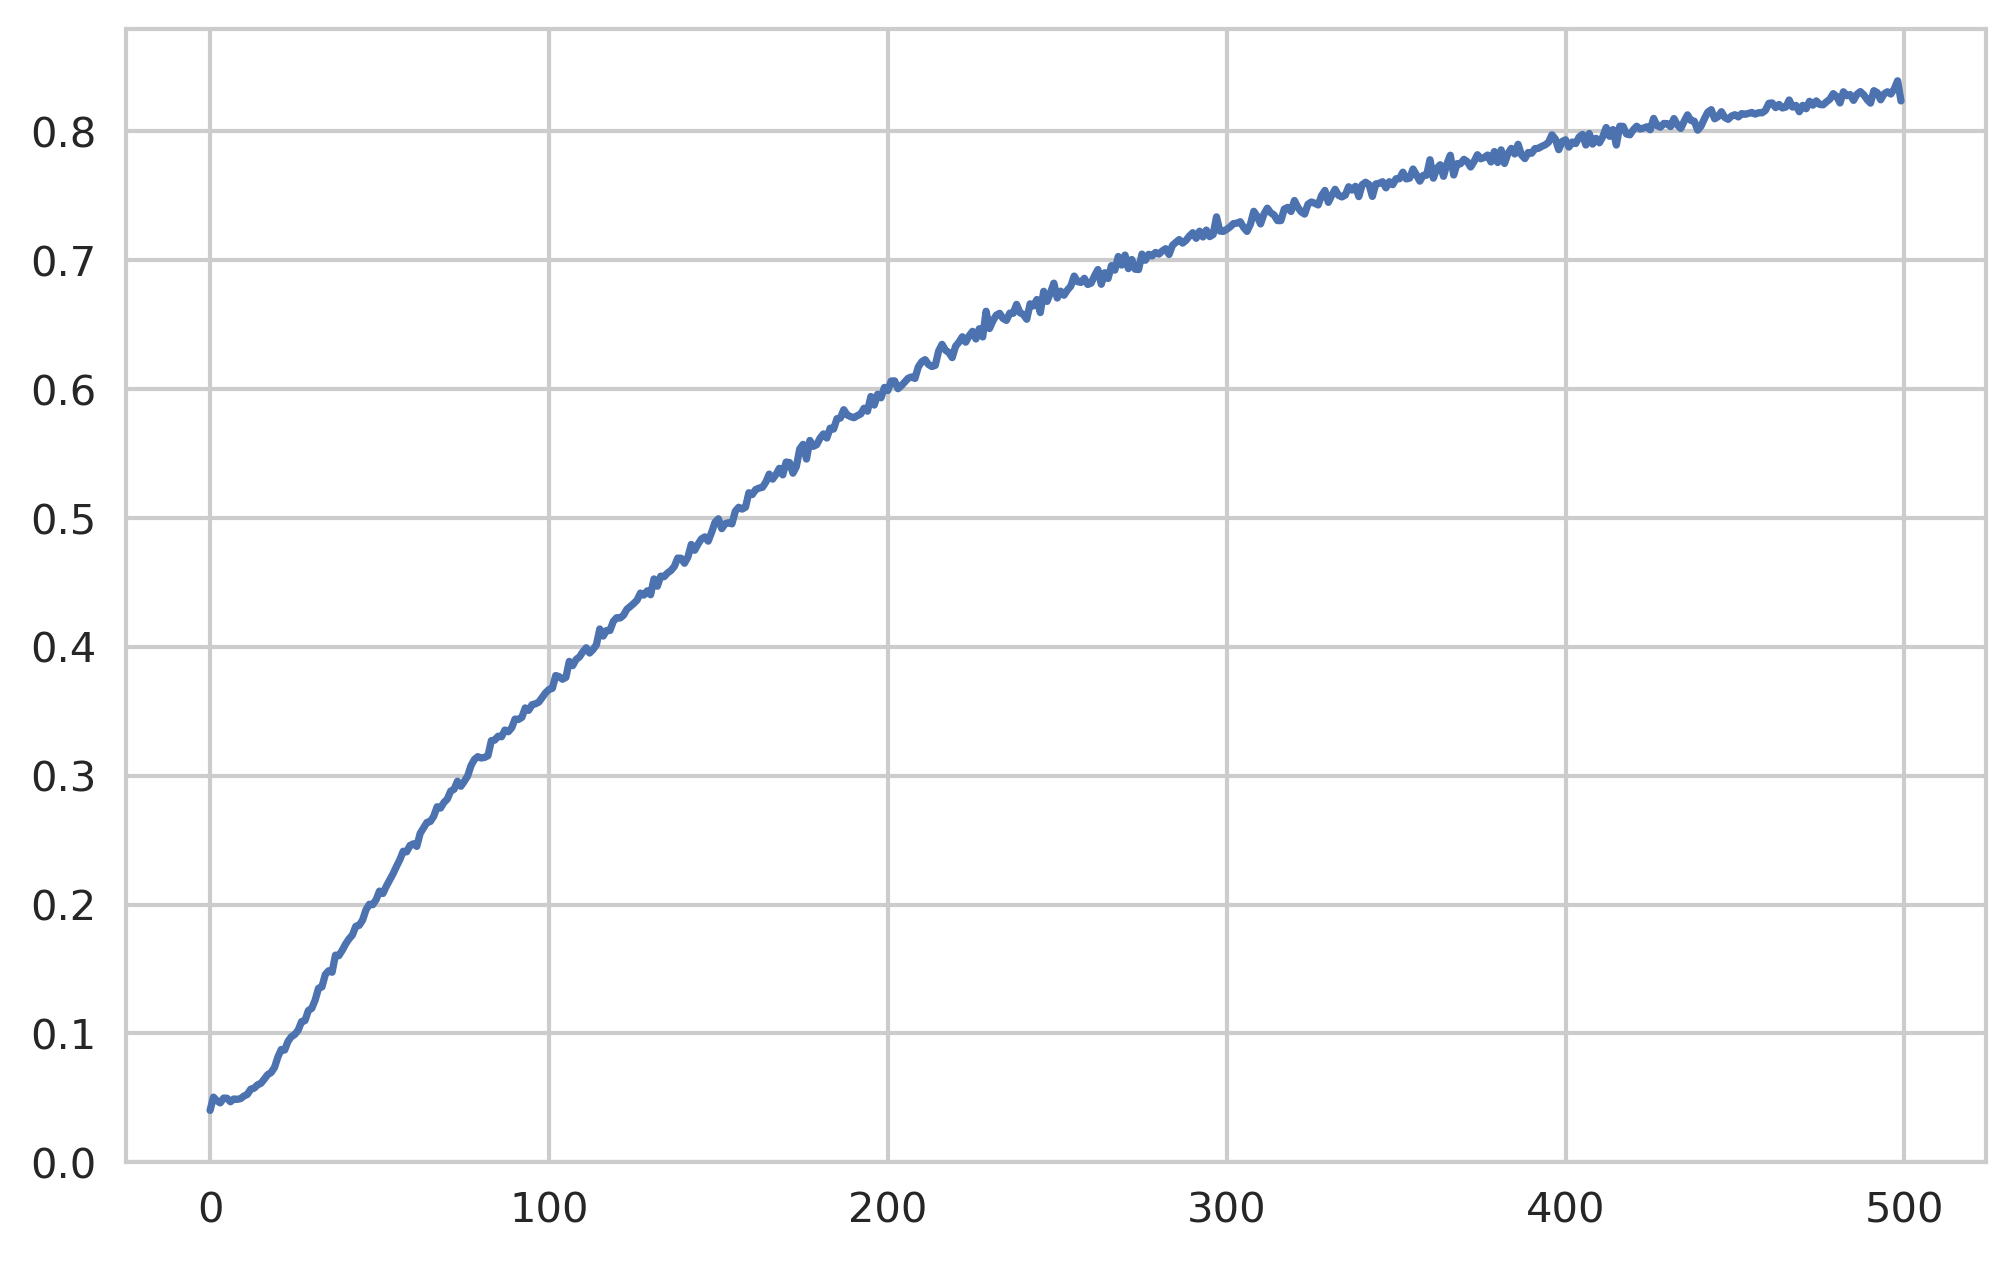

In [98]:
plt.plot(hist.history['acc'])
plt.show()

In [99]:
model.save("rnn_text_gen.hdf5")

## Test

In [16]:
from keras.models import load_model
model = load_model("rnn_text_gen.hdf5")

In [17]:
word_list = '대한민국 의 국민 이 되는 요건 은 법률 로 정한 다 .'.split(" ")
word_list

['대한민국', '의', '국민', '이', '되는', '요건', '은', '법률', '로', '정한', '다', '.']

In [18]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [19]:
len(reverse_word_map)

1204

In [20]:
x = sequence.pad_sequences([[tokenizer.word_index[w] for w in word_list[:2]]], maxlen=maxlen)
x

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [21]:
p = model.predict(x)[0]
p

array([5.1314508e-08, 1.1153760e-03, 3.6256557e-04, ..., 6.6387229e-06,
       1.3235493e-07, 1.3641418e-05], dtype=float32)

In [22]:
idx = np.flip(np.argsort(p), 0)
idx

array([ 438,  437,   19, ...,  605, 1170,  286])

In [23]:
p[idx]

array([1.76298395e-01, 1.67277738e-01, 5.77470176e-02, ...,
       1.06850376e-10, 7.99032368e-11, 7.51542578e-11], dtype=float32)

In [24]:
for i in idx[:5]:
    print(reverse_word_map[i])

영토
주권
국민
조직
종류


In [53]:
def predict_word(i, n=1):
    x = sequence.pad_sequences([[tokenizer.word_index[w] for w in word_list[:i]]], maxlen=maxlen)
    p = model.predict(x)[0]
    idx = np.flip(np.argsort(p), 0)
    for j in idx[:n]:
        print('"', " ".join(word_list[:i]), '"', reverse_word_map[j], " (p={:4.2f}%)".format(100 * p[j]))

In [54]:
predict_word(1, n=3)

" 대한민국 " 의  (p=62.61%)
" 대한민국 " 은  (p=30.96%)
" 대한민국 " 헌법  (p=1.82%)


In [55]:
predict_word(2, n=3)

" 대한민국 의 " 영토  (p=17.63%)
" 대한민국 의 " 주권  (p=16.73%)
" 대한민국 의 " 국민  (p=5.77%)


In [56]:
predict_word(3, n=3)

" 대한민국 의 국민 " 은  (p=62.33%)
" 대한민국 의 국민 " 이  (p=17.43%)
" 대한민국 의 국민 " 의  (p=11.92%)


In [57]:
predict_word(4, n=3)

" 대한민국 의 국민 이 " 되는  (p=74.99%)
" 대한민국 의 국민 이 " 헌법  (p=10.13%)
" 대한민국 의 국민 이 " 에  (p=2.34%)


In [58]:
predict_word(5, n=3)

" 대한민국 의 국민 이 되는 " 요건  (p=98.50%)
" 대한민국 의 국민 이 되는 " 계약  (p=0.34%)
" 대한민국 의 국민 이 되는 " 되는  (p=0.21%)


In [59]:
predict_word(6, n=3)

" 대한민국 의 국민 이 되는 요건 " 은  (p=95.34%)
" 대한민국 의 국민 이 되는 요건 " 의  (p=2.49%)
" 대한민국 의 국민 이 되는 요건 " 이  (p=1.59%)


In [60]:
predict_word(7, n=3)

" 대한민국 의 국민 이 되는 요건 은 " 법률  (p=97.38%)
" 대한민국 의 국민 이 되는 요건 은 " 국가  (p=1.09%)
" 대한민국 의 국민 이 되는 요건 은 " 대통령  (p=0.53%)


In [61]:
predict_word(8, n=3)

" 대한민국 의 국민 이 되는 요건 은 법률 " 로  (p=97.31%)
" 대한민국 의 국민 이 되는 요건 은 법률 " 이  (p=1.63%)
" 대한민국 의 국민 이 되는 요건 은 법률 " 로써  (p=0.68%)


In [62]:
predict_word(9, n=3)

" 대한민국 의 국민 이 되는 요건 은 법률 로 " 정한  (p=99.61%)
" 대한민국 의 국민 이 되는 요건 은 법률 로 " 정하되  (p=0.11%)
" 대한민국 의 국민 이 되는 요건 은 법률 로 " 인하여  (p=0.02%)


In [63]:
predict_word(10, n=3)

" 대한민국 의 국민 이 되는 요건 은 법률 로 정한 " 다  (p=99.90%)
" 대한민국 의 국민 이 되는 요건 은 법률 로 정한 " 국회  (p=0.03%)
" 대한민국 의 국민 이 되는 요건 은 법률 로 정한 " 후  (p=0.01%)


In [71]:
def generate(w, n, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    
    def _predict_word(sent):
        x = sequence.pad_sequences([[tokenizer.word_index[w] for w in sent]], maxlen=maxlen)
        p = model.predict(x)[0]
        logp = np.log(p)
        p = np.exp(logp) / np.sum(np.exp(logp))
        p = p[1:]
        return np.random.choice(list(tokenizer.word_index.keys()), p=p)

    sent = [w]
    for i in range(n):
        w = _predict_word(sent)
        sent.append(w)
        
    return " ".join(sent)

In [77]:
generate("대한민국", 10, seed=1)

'대한민국 의 영토 의 피고인 은 법률 이 정하는 바 에'

In [78]:
generate("대한민국", 10, seed=2)

'대한민국 의 국민 은 법률 이 정하는 바 에 의하여 국가'

In [79]:
generate("대한민국", 10, seed=3)

'대한민국 의 영토 는 한반도 와 그 부속 도서 로 한'

In [80]:
generate("국민", 10, seed=1)

'국민 은 국무회의 의 항 과 국가 의 기본 적 인'

In [81]:
generate("국민", 10, seed=2)

'국민 은 이 경우 를 제외 하고는 심사 하여 그 정책'

In [82]:
generate("국민", 10, seed=3)

'국민 은 국무회의 의 의장 국무총리 국무위원 의 동의 를 얻어'

In [86]:
generate("세계", 10, seed=3)

'세계 조직 과 집회 결사 에 대한 집회 가 그 절차'